<a href="https://colab.research.google.com/github/realfolkcode/AdversarialRegularization/blob/main/filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import

In [1]:
import os
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
!git clone https://github.com/realfolkcode/AdversarialRegularization.git

Cloning into 'AdversarialRegularization'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 65 (delta 27), reused 23 (delta 6), pack-reused 0
Unpacking objects: 100% (65/65), done.


In [3]:
from AdversarialRegularization.utils import *

# Loading Models

In [4]:
class CNN(nn.Module):
    def __init__(self, num_classes=100):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.features(x)
        x = self.classifier(x)
        return x

We want to collect good filters. For that purpose, we load models that have been trained on a large dataset. These models differ only in initial weight initialization.

In [5]:
model_dir = 'AdversarialRegularization/models/'
model_lst = []

for model_name in os.listdir('AdversarialRegularization/models/'):
    model_path = os.path.join(model_dir, model_name)
    model = CNN(num_classes=100)
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    model_lst.append(model)

In [6]:
model_lst[0]

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (classifier): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=256, out_features=100, bias=True)
  )
)

In [7]:
print('Number of models:', len(model_lst))

Number of models: 5


# Filter Dataset

Let us create a class for filters dataset to make life easier. We will use it to train discriminators. As input, it would take a list of convolution layers (kernel sizes must be the same).

In [8]:
class FilterDataset(Dataset):
    def __init__(self, layer_lst):
        self.kernels = [layer.weight.data.clone() for layer in layer_lst]
        self.kernels = torch.cat(self.kernels)
        c_out, c_in, h, w = self.kernels.shape
        self.kernels = self.kernels.view(c_out * c_in, -1, h, w)
    
    def __len__(self):
        return len(self.kernels)
    
    def __getitem__(self, idx):
        return self.kernels[idx]

In [9]:
model_lst[0].features[0]

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [10]:
RANDOM_SEED = 0
set_random_seeds(seed_value=RANDOM_SEED, device=device)

In [11]:
filters_data = []
filters_loader = []

# Create datasets for 7x7, 5x5, 5x5 kernels from corresponding convolution layers 
filters_data.append(FilterDataset([model.features[0] for model in model_lst]))
filters_data.append(FilterDataset([model_lst[0].features[3]]))
filters_data.append(FilterDataset([model_lst[0].features[6]]))

# Create dataloaders for filters datasets
for i in range(len(filters_data)):
    filters_loader.append(DataLoader(filters_data[i], batch_size=32, shuffle=True))

In [12]:
for i in range(len(filters_loader)):
    print(f'Filter Dataset {i} size: {len(filters_loader[i].dataset)}')

Filter Dataset 0 size: 960
Filter Dataset 1 size: 8192
Filter Dataset 2 size: 16384


Now, we can iterate over filters dataset.

In [13]:
for batch in filters_loader[0]:
    print(batch)
    break

tensor([[[[-0.0879, -0.0739, -0.0795,  ...,  0.0731,  0.0798,  0.0049],
          [-0.0744,  0.0545,  0.0253,  ...,  0.2629,  0.1220,  0.0514],
          [ 0.0422,  0.2136,  0.3394,  ...,  0.2163, -0.0506, -0.2390],
          ...,
          [ 0.1515,  0.1743, -0.0196,  ..., -0.3626, -0.2900, -0.0979],
          [ 0.0293,  0.0629, -0.1564,  ..., -0.2374, -0.1608,  0.0408],
          [-0.0488, -0.0688, -0.1477,  ..., -0.0452,  0.0429,  0.2405]]],


        [[[ 0.0025,  0.0336, -0.0175,  ...,  0.1137,  0.1465,  0.1374],
          [-0.0019,  0.0114,  0.0537,  ...,  0.1063,  0.1444,  0.0270],
          [ 0.0727,  0.0320,  0.0763,  ...,  0.1393,  0.1422,  0.0022],
          ...,
          [ 0.0276, -0.0455,  0.0459,  ..., -0.0118, -0.0496, -0.1666],
          [ 0.0085, -0.0285, -0.0370,  ..., -0.1572, -0.1378, -0.1835],
          [-0.0284, -0.1524, -0.2105,  ..., -0.2875, -0.1830, -0.2405]]],


        [[[ 0.0039, -0.0441, -0.0199,  ...,  0.0432, -0.0778, -0.0106],
          [ 0.0023,  0.041

We can also visualize kernels to check if our dataset contains patterns.

In [14]:
def plot_kernels(loader, nrow=8):
    dataiter = iter(loader)
    batch = dataiter.next()
    rows = np.min((batch.shape[0] // nrow + 1, 64))    
    grid = torchvision.utils.make_grid(batch, nrow=nrow, normalize=True, padding=1)
    plt.figure(figsize=(nrow,rows))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

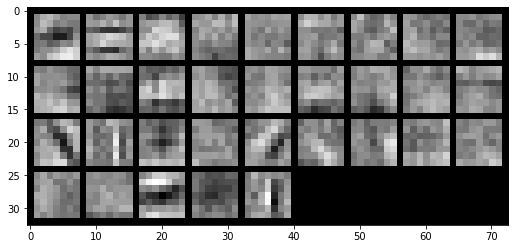

In [15]:
plot_kernels(filters_loader[0], nrow=9)

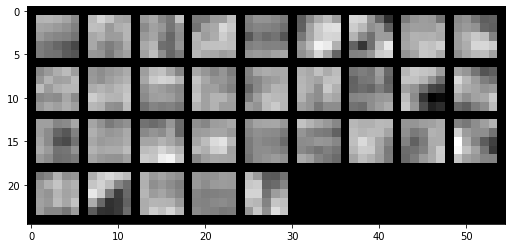

In [16]:
plot_kernels(filters_loader[1], nrow=9)

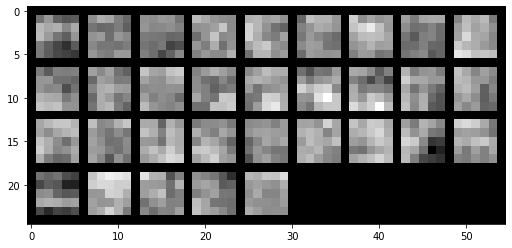

In [17]:
plot_kernels(filters_loader[2], nrow=9)

# Prepare data

Now we load CIFAR10 and take a small subset of it. We restrict this subset to have equal number of images per class to make dataset balanced.

In [18]:
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(0.5, 0.5)])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(0.5, 0.5)])

train_set = torchvision.datasets.CIFAR10('./cifar10', train=True, download=True,
                                         transform=train_transform)

test_set = torchvision.datasets.CIFAR10('./cifar10', train=False, download=True,
                                        transform=test_transform)

print('Train size', len(train_set))
print('Test size', len(test_set))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified
Train size 50000
Test size 10000


In [19]:
train_size = 100 / len(train_set)
test_size = 10 / len(test_set)

In [20]:
train_idx, _ = train_test_split(np.arange(len(train_set)),
                                train_size=train_size,
                                shuffle=True,
                                random_state=42,
                                stratify=train_set.targets)

_, test_idx = train_test_split(np.arange(len(test_set)),
                               test_size=test_size,
                               shuffle=True,
                               random_state=42,
                               stratify=test_set.targets)

Let's make sure that the obtained indices are indeed stratified by classes.

In [ ]:
pd.DataFrame(train_set.targets).rename(columns={0: 'class'}).iloc[train_idx].groupby('class').size()

class
0    10
1    10
2    10
3    10
4    10
5    10
6    10
7    10
8    10
9    10
dtype: int64

In [ ]:
pd.DataFrame(test_set.targets).rename(columns={0: 'class'}).iloc[test_idx].groupby('class').size()

class
0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
dtype: int64

In [ ]:
train_set = Subset(train_set, train_idx)
test_set = Subset(test_set, test_idx)

In [ ]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

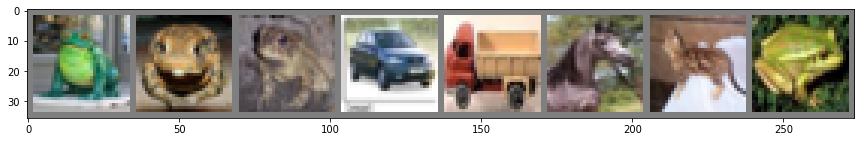

In [ ]:
plot_random_images(train_loader)

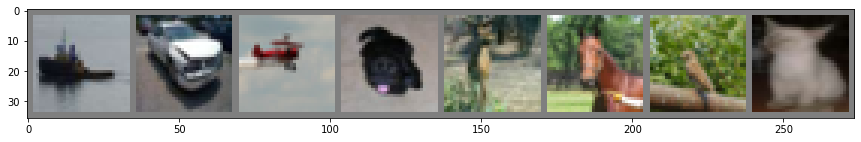

In [ ]:
plot_random_images(test_loader)

# Training on small dataset

# Discriminators

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 1, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [ ]:
RANDOM_SEED = 0
set_random_seeds(seed_value=RANDOM_SEED, device=device)

netD = Discriminator().to(device)
netD.apply(weights_init)
print('Number of weights:', np.sum([np.prod(p.shape) for p in netD.parameters()]))

Number of weights: 75840


In [ ]:
netD

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): Sigmoid()
  )
)

In [ ]:
netD(torch.ones((1, 1, 7, 7))).shape

torch.Size([1, 1, 7, 7])

In [ ]:
# Initialize criterions for classifier and discriminator
criterion_clf = nn.CrossEntropyLoss()
criterion_D = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both classifier and discriminator
opt_clf = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
opt_D = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
def epoch_discriminator(real_loader, fake_loader, netD, criterion_D, opt_D):
    for i, real_batch in enumerate(real_loader):
        #############################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_batch = real_batch.to(device)
        b_size = real_batch.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_batch).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion_D(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        #############################
        ## Train with all-fake batch
        # Format batch
        fake_batch = next(iter(fake_loader))
        b_size = fake_batch.size(0)
        label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
        # Classify all fake batch with D
        output = netD(fake_batch.detach()).view(-1)
        # Calculate D's loss on the all-fake batch

In [ ]:
def epoch_train(img_loader, clf, netD, criterion_clf, criterion_D, opt_clf, opt_D):
    # Update classifier
    clf.train()
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)
        output = clf(data)
        loss = criterion(output, target)

        opt.zero_grad()
        loss.backward()
        opt.step()
    
    # Evaluation
    clf.eval()
    train_loss = 0
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            output = clf(data)
            train_loss += criterion(output, target).item()
    train_acc = get_accuracy(clf, loader, device)
    train_loss /= len(loader.dataset

In [ ]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0

n_epochs = 100

print("Starting Training Loop...")
for epoch in tqdm(range(n_epochs)):
    pass